In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import tensorflow as tf
keras = tf.keras

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM


In [2]:
astra_data = pd.read_csv('/kaggle/input/nse-defence-stocks-india/ASTRAMICRO.NS.csv', index_col='Date')

In [3]:
astra_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-01,26.733334,28.000000,25.466665,27.973333,23.467009,153375
2004-11-08,29.333332,29.333332,27.466665,27.866667,23.377522,47760
2004-11-15,27.866667,28.966665,27.000000,27.466665,23.041958,42465
2004-11-22,27.933332,30.700001,27.333332,30.506666,25.592236,156330
2004-11-29,30.593332,31.093332,27.420000,27.773333,23.299223,56370


<AxesSubplot:xlabel='Date'>

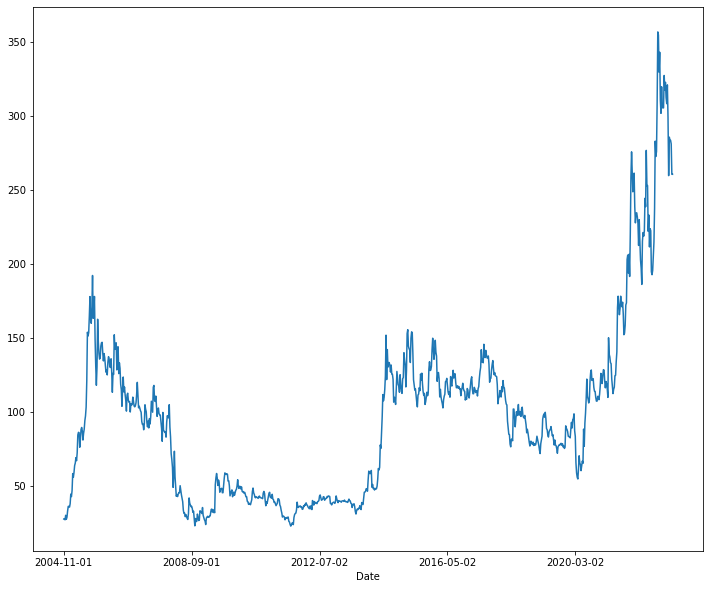

In [4]:
astra_data['Close'].plot(figsize=(12,10))

In [5]:
astra_data = astra_data.dropna()

In [6]:
len(astra_data)

953

In [7]:
scaled_astra_data = scaler.fit_transform(astra_data)

In [8]:
scaled_astra_data.shape

(953, 6)

In [9]:
look_back = 6

astra_data_generator = TimeseriesGenerator(scaled_astra_data, scaled_astra_data, length=look_back, batch_size=1)

In [10]:
astra_model = Sequential()

n_features = scaled_astra_data.shape[1]

astra_model.add(LSTM(128, activation='relu', return_sequences=True , input_shape=(look_back,n_features)))
astra_model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(look_back,n_features)))
astra_model.add(LSTM(512, activation='relu',  input_shape=(look_back,n_features)))

astra_model.add(Dense(n_features))

astra_model.compile(optimizer='adam', loss='mse')

2023-02-03 12:03:05.783147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:03:05.792167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:03:05.792850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:03:05.794162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
astra_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 256)            394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 2,041,350
Trainable params: 2,041,350
Non-trainable params: 0
_________________________________________________________________


In [12]:
astra_model.fit(astra_data_generator, epochs=500)

2023-02-03 12:03:21.580180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
947/947 [==============================] - 39s 39ms/step - loss: 0.0095
Epoch 2/500
947/947 [==============================] - 38s 40ms/step - loss: 0.0041
Epoch 3/500
947/947 [==============================] - 36s 38ms/step - loss: 0.0040
Epoch 4/500
947/947 [==============================] - 36s 38ms/step - loss: 0.0030
Epoch 5/500
947/947 [==============================] - 36s 38ms/step - loss: 0.0031
Epoch 6/500
947/947 [==============================] - 36s 38ms/step - loss: 0.0022
Epoch 7/500
947/947 [==============================] - 37s 39ms/step - loss: 0.0021
Epoch 8/500
947/947 [==============================] - 37s 39ms/step - loss: 0.0022
Epoch 9/500
947/947 [==============================] - 37s 39ms/step - loss: 0.0022
Epoch 10/500
947/947 [==============================] - 36s 38ms/step - loss: 0.0018
Epoch 11/500
947/947 [==============================] - 37s 39ms/step - loss: 0.0021
Epoch 12/500
947/947 [==============================] - 36s 38ms/step - lo

In [13]:
astra_model.save('/kaggle/working/astra_model.h5')

In [15]:
# for exporting important objects of model
import joblib

# create PKL files of important objects required for project
# these are required for prediction of future stock prices and also for the flask app
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
joblib.dump(scaled_astra_data, "/kaggle/working/scaled_astra_data.pkl")
joblib.dump(look_back, "/kaggle/working/look_back.pkl")

['/kaggle/working/look_back.pkl']

<AxesSubplot:>

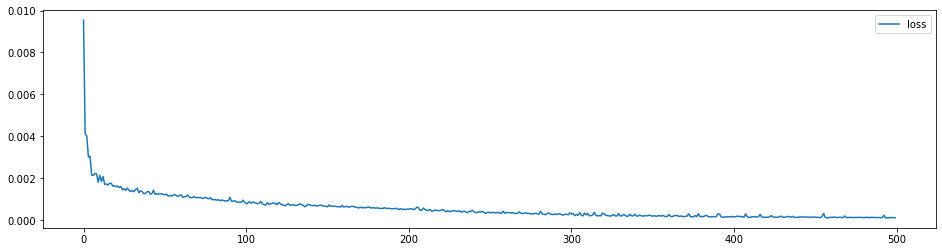

In [17]:
astra_loss = pd.DataFrame(astra_model.history.history)
astra_loss.plot(figsize=(16,4))